In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
import time
import torch
import torch.nn.functional as F

np.random.seed(42)
nnfs.init()

Argmax

In [4]:

max(enumerate((1,2,3,10,4,5)), key=lambda x: x[1])

(3, 10)

## Categorical Cross-Entropy

### Definition

$$
Loss_i = -\sum_j y_{i,j} \log(\hat{y}_{i,j})
$$

</br>

$$
Loss = -\sum (\text{true label} \times \log(\text{predicted probability}))
$$

#### **Probabilistic Interpretation of Cross-Entropy**

Categorical cross-entropy is rooted in **information theory** and **probability theory**. Here’s how:

##### **1. Likelihood and Log-Likelihood**

- In classification, your model outputs a probability distribution over classes for each input.
- The **likelihood** of the true class, given the model’s prediction, is simply the predicted probability assigned to the correct class.
- For a dataset, the **likelihood** is the product of these probabilities across all samples.
- To make optimization easier (products can become very small), we use the **log-likelihood** (sum of logs instead of product).

##### **2. Negative Log-Likelihood**

- The **negative log-likelihood** (NLL) is what we minimize during training.
- For a single sample, if the true class is \(j\), and the predicted probability for class \(j\) is \(\hat{y}_j\), the NLL is:
  \[
  -\log(\hat{y}_j)
  \]
- For one-hot encoded labels, this generalizes to:
  \[
  -\sum_j y_j \log(\hat{y}_j)
  \]
  where \(y_j\) is 1 for the true class and 0 otherwise.

##### **3. Cross-Entropy as Expected Surprise**

- **Cross-entropy** measures the expected number of bits needed to encode the true labels using the predicted probabilities.
- Lower cross-entropy means the predicted distribution is closer to the true distribution.
- The log term quantifies the "surprise" of the model when it sees the true class, given its predicted probability.

##### **4. Why Log?**

- The log function is used because probabilities multiply across independent events, but logs turn products into sums, which are easier to optimize.
- Logarithms also have the property of heavily penalizing low probabilities for the true class, which is desirable for learning.

---

#### **When is Categorical Cross-Entropy Not Suitable?**

Categorical cross-entropy is **not suitable** for all classification tasks. Here are cases where it’s inappropriate:

##### **1. Non-Exclusive Classes (Multi-Label Classification)**

- **Categorical cross-entropy** assumes each sample belongs to exactly one class (mutually exclusive classes).
- If a sample can belong to **multiple classes at once** (multi-label classification), use **binary cross-entropy** (BCE) instead, applied independently to each class.

##### **2. Regression Tasks**

- Cross-entropy is not suitable for regression (predicting continuous values). Use losses like **mean squared error (MSE)** for regression.

##### **3. Unnormalized Outputs**

- Categorical cross-entropy expects the model outputs to be **probabilities** (i.e., non-negative and sum to 1, usually via softmax).
- If your model outputs are not normalized, you must apply softmax before using this loss.

##### **4. Ordinal Classification**

- If your classes have a natural order (ordinal data), specialized losses or regression approaches may be more appropriate.

---

#### **Summary Table**

| Task Type                        | Suitable Loss Function                |
|-----------------------------------|---------------------------------------|
| Single-label, multi-class         | Categorical cross-entropy             |
| Multi-label (multiple classes per sample) | Binary cross-entropy (BCE)    |
| Regression (continuous output)    | Mean squared error (MSE), etc.        |
| Ordinal classification            | Ordinal regression or specialized loss|

---

**In summary:**
Categorical cross-entropy is a probabilistically principled loss for single-label, multi-class classification, measuring how well the predicted probability distribution matches the true distribution. It is not suitable for multi-label, regression, or ordinal tasks.

**Implications of Returning Per-Sample Loss**
- Granularity: You get the loss for each sample, which is useful for analysis, debugging, or custom loss aggregation (e.g., weighted losses).
- Training: Most deep learning frameworks expect a scalar loss for backpropagation. If you return per-sample losses, you’ll need to aggregate them (e.g., with .mean() or .sum()) before calling .backward().
- Flexibility: Returning per-sample loss gives you more control, but you must remember to aggregate when needed.

**Summary Table**
|Return Value|	Shape|	Typical Use Case|
|------------|--------|------------------|
|Mean loss (scalar)|	()|	Standard training/backpropagation|
|Per-sample loss|	(batch_size,)|	Analysis, custom aggregation, debugging|

### Code implementations

#### Numpy cross-entropy

In [52]:
def categorical_cross_entropy_numpy(y_pred, y_true, epsilon = 1e-15, verbose = False):
    """
    Computes the categorical cross-entropy loss.

    Parameters:
        y_true: numpy array of shape (n_samples, n_classes), one-hot encoded true labels
        y_pred: numpy array of shape (n_samples, n_classes), predicted probabilities
        epsilon: small value to avoid log(0)

    Returns:
        loss: scalar, mean categorical cross-entropy loss
    """   
    # Clip predictions to prevent log(0)
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred_clipped), axis=1, keepdims=True)
    output = np.mean(loss)
    if verbose:
        print("y_pred:", y_pred)
        print("\ny_pred_clipped:", y_pred_clipped)
        print("\ny_true:", y_true)
        print("\nlog clipped:", np.log(y_pred_clipped))
        print("\nSum Loss: ", loss)
        print("\nLoss Output Numpy: ", output)

    
    # Calculate loss
    return output
    # return np.mean(loss, axis=0)[0]

#### Torch cross-entropy

In [51]:
def categorical_cross_entropy_torch(y_pred, y_true, verbose=False, epsilon=1e-15):
    """
    Computes the categorical cross-entropy loss.

    Parameters:
        y_true: torch tensor of shape (n_samples, n_classes), one-hot encoded true labels
        y_pred: torch tensor of shape (n_samples, n_classes), predicted probabilities
        verbose: bool, if True prints intermediate values
        epsilon: small value to avoid log(0)

    Returns:
        loss: scalar, mean categorical cross-entropy loss
    """
    # Clip predictions to avoid log(0)
    y_pred_clipped = torch.clamp(y_pred, epsilon, 1. - epsilon)
        
    # Compute cross-entropy
    log_preds = torch.log(y_pred_clipped)        
    elementwise_loss = -y_true * log_preds        
    sample_loss = torch.sum(elementwise_loss, dim=1)        
    mean_loss = torch.mean(sample_loss)
        
    if verbose:
        print("y_pred:", y_pred)
        print("Clipped predictions:\n", y_pred_clipped)
        print("Log of predictions:\n", log_preds)
        print("Elementwise loss:\n", elementwise_loss)
        print("Sample-wise loss:\n", sample_loss)
        print("Mean loss Torch (output):", mean_loss.item())
    
    return mean_loss

#### Tests

In [ ]:
# Create sample data
batch_size = 3 # Number of samples in the batch
num_classes = 4 # (0, 1, 2, 3)

Numpy test

In [44]:
y_true = np.zeros((batch_size, num_classes))
y_true[0, 0] = 1    # Class 0
y_true[1, 2] = 1    # Class 2
y_true[2, 1] = 1    # Class 1
y_pred = np.array([[0.5, 0.45, 0.025, 0.025], # Class 0
                   [0.1, 0.2, 0.7, 0], # Class 2
                   [0.01, 0.96, 0.005, 0.025]]) # Class 1

print('Suma (check):', np.sum(y_pred, axis=1)) # Check that the sum is 1
print('\nReal:\n', y_true)
print('\nProbabilidades de las predicciones:\n', y_pred)

Suma (check): [1. 1. 1.]

Real:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

Probabilidades de las predicciones:
 [[0.5   0.45  0.025 0.025]
 [0.1   0.2   0.7   0.   ]
 [0.01  0.96  0.005 0.025]]


In [ ]:
output_loss = categorical_cross_entropy_numpy(y_pred, y_true, verbose=True) # Numpy version

y_pred: [[0.5   0.45  0.025 0.025]
 [0.1   0.2   0.7   0.   ]
 [0.01  0.96  0.005 0.025]]

y_pred_clipped: [[5.0e-01 4.5e-01 2.5e-02 2.5e-02]
 [1.0e-01 2.0e-01 7.0e-01 1.0e-15]
 [1.0e-02 9.6e-01 5.0e-03 2.5e-02]]

y_true: [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

log clipped: [[ -0.69314718  -0.7985077   -3.68887945  -3.68887945]
 [ -2.30258509  -1.60943791  -0.35667494 -34.53877639]
 [ -4.60517019  -0.04082199  -5.29831737  -3.68887945]]

Sum Loss:  [[0.69314718]
 [0.35667494]
 [0.04082199]]

Loss Output:  0.3635480396729777


Torch test

In [46]:
y_true = torch.zeros((batch_size, num_classes))
y_true[0, 0] = 1    # Class 0
y_true[1, 2] = 1    # Class 2
y_true[2, 1] = 1    # Class 1
y_pred = torch.tensor([[0.5, 0.45, 0.025, 0.025], # Class 0
                   [0.1, 0.2, 0.7, 0], # Class 2
                   [0.01, 0.96, 0.005, 0.025]]) # Class 1

In [50]:
output_loss = categorical_cross_entropy_torch(y_pred, y_true, verbose=True) # Torch version

y_pred: tensor([[0.5000, 0.4500, 0.0250, 0.0250],
        [0.1000, 0.2000, 0.7000, 0.0000],
        [0.0100, 0.9600, 0.0050, 0.0250]])
Clipped predictions:
 tensor([[5.0000e-01, 4.5000e-01, 2.5000e-02, 2.5000e-02],
        [1.0000e-01, 2.0000e-01, 7.0000e-01, 1.0000e-15],
        [1.0000e-02, 9.6000e-01, 5.0000e-03, 2.5000e-02]])
Log of predictions:
 tensor([[ -0.6931,  -0.7985,  -3.6889,  -3.6889],
        [ -2.3026,  -1.6094,  -0.3567, -34.5388],
        [ -4.6052,  -0.0408,  -5.2983,  -3.6889]])
Elementwise loss:
 tensor([[0.6931, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3567, 0.0000],
        [0.0000, 0.0408, 0.0000, 0.0000]])
Sample-wise loss:
 tensor([0.6931, 0.3567, 0.0408])
Mean loss (output): 0.36354804039001465


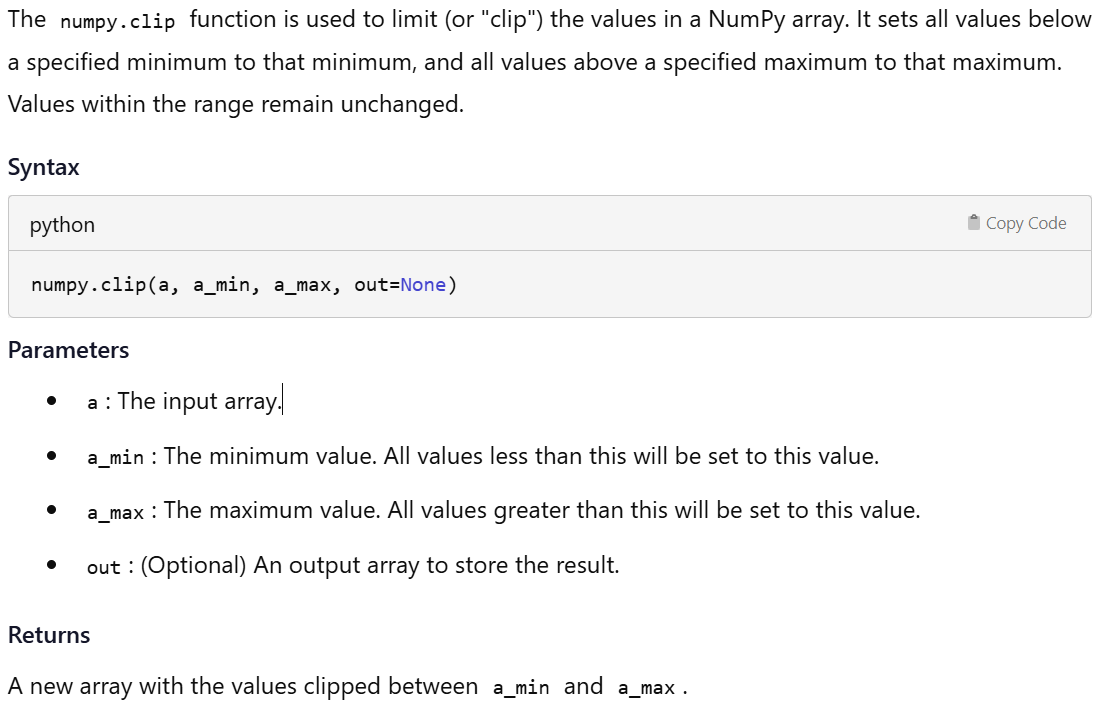

In [ ]:
arr = np.array([1, 5, 8, 10, 15])
clipped = np.clip(arr, 3, 10)
print(clipped)

[ 3  5  8 10 10]


A medida que las dimensiones de los inputs escalen, la media se podrá mantener en rangos de valores buenos mientras que la suma corre el riesgo de acabar produciendo buffer overflow

Test_use. Numpy

In [40]:
# Categorical cross-entropy loss function
def categorical_cross_entropy_torch_numpy(y_pred, y_true, epsilon = 1e-15):
    # Clip predictions to prevent log(0)
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    # Calculate loss
    return -np.sum(y_true * np.log(y_pred_clipped), axis=1, keepdims=True)

# Calculate loss
loss = categorical_cross_entropy_torch_numpy(y_true, y_pred)
print(loss)
# print(f"Categorical Cross-Entropy Loss: {loss.item()}")

[[17.2693882 ]
 [10.36163292]
 [ 1.38155106]]


La loss-function es proporcional a como de lejos está el valor correcto del valor real

Returning the mean loss is generally better for most training scenarios because:

1. Scale invariance: Mean loss normalizes by batch size, making the loss value consistent regardless of batch size, which helps maintain stable learning rates.
2. Gradient scaling: When using mean loss, gradients aren't artificially inflated by larger batch sizes, leading to more consistent optimization.
3. Comparability: Mean loss allows you to compare performance across different batch sizes and datasets.
4. Standard practice: Most deep learning frameworks (PyTorch, TensorFlow) use mean reduction by default for their loss functions.

However, if you need to weight samples differently or implement custom reduction logic, you might want to return the unreduced loss (before taking the mean) and handle reduction separately.

In [15]:
batch_size = 3 # Number of samples in the batch
num_classes = 4 # (0, 1, 2, 3)

# One-hot encoded ground truth
y_true = torch.zeros(batch_size, num_classes)
y_true[0, 1] = 1.0  # First sample belongs to class 1
y_true[1, 0] = 1.0  # Second sample belongs to class 0
y_true[2, 2] = 1.0  # Third sample belongs to class 2

# Predicted probabilities (output from softmax)
y_pred = torch.tensor([[0.5, 0.45, 0.025, 0.025], # Prediction for first sample. Class 1 probability is 0.45
                   [0.7, 0.1, 0.2, 0], # Prediction for second sample. Class 0 probability is 0.7
                   [0.01, 0.005, 0.96, 0.025]]) # Prediction for third sample. Class 2 probability is 0.96

print('Suma (check):', torch.sum(y_pred, dim=1, keepdim=True)) # Check that the sum is 1
print('\nReal:\n', y_true)
print('\nPredicciones:\n', y_pred)

# Categorical cross-entropy loss function
def categorical_cross_entropy_torch(y_pred, y_true, epsilon=1e-15):
    # Clip predictions to prevent log(0)
    y_pred_clipped = torch.clamp(y_pred, epsilon, 1 - epsilon)
    # Calculate loss
    # Note: PyTorch's log function is already element-wise and handles broadcasting, so we can directly use it
    loss = -torch.sum(y_true * torch.log(y_pred_clipped), dim=1, keepdim=True)
    return loss


# Compare with PyTorch's built-in function
# For torch.nn.functional.cross_entropy, we need class indices, not one-hot
targets = torch.tensor([1,0,2])  # Class indices
# Note: F.cross_entropy expects raw logits, not softmax probabilities
# For demonstration, we'll convert probabilities back to approximate logits
logits = torch.log(y_pred)
pytorch_loss = F.cross_entropy(logits, targets)
print(f"\nPyTorch's Cross-Entropy Loss: {pytorch_loss}")
print(f"PyTorch's Cross-Entropy Loss: {pytorch_loss.item()}")

Suma (check): tensor([[1.0000],
        [1.0000],
        [1.0000]])

Real:
 tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])

Predicciones:
 tensor([[0.5000, 0.4500, 0.0250, 0.0250],
        [0.7000, 0.1000, 0.2000, 0.0000],
        [0.0100, 0.0050, 0.9600, 0.0250]])

PyTorch's Cross-Entropy Loss: 0.39866816997528076
PyTorch's Cross-Entropy Loss: 0.39866816997528076
